Run In Place Analysis
=================================

This notebook contains the analysis for implementing walk in place inside the godot_oculus_quest_toolkit
The implementation is based on the paper [*A Walking-in-Place Method for Virtual Reality Using Position and Orientation Tracking*](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6165345/pdf/sensors-18-02832.pdf)

In [1]:
# NOTE: restart kernel when swithcing between inline and notebook
#       inline will store images inside notebook; notebook will allow interactive plots
%matplotlib inline
#%matplotlib notebook 

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import json, os
import glm
import numpy as np

In [2]:
os.listdir("data/") # list the files in a subolder

['test_recording.oqrec', 'walkInPlace_001_runningAround.oqrec']

In [3]:
rec = json.load(open('data/walkInPlace_001_runningAround.oqrec')) # load the recording as a json

In [4]:
# Print some info about the loaded recording
print("num_frames = %d; fps = %d; start_time = %s" % (rec["num_frames"], rec["target_fps"], rec["start_time"]))
print("Keys in the recording are:")
for k in rec.keys(): print('"'+k+'"', end = ' ') # show the keys of all the arrays in the recording


num_frames = 2705; fps = 72; start_time = 2019.12.09_20.57.32
Keys in the recording are:
"head_orientation" "head_position" "num_frames" "start_time" "target_fps" 

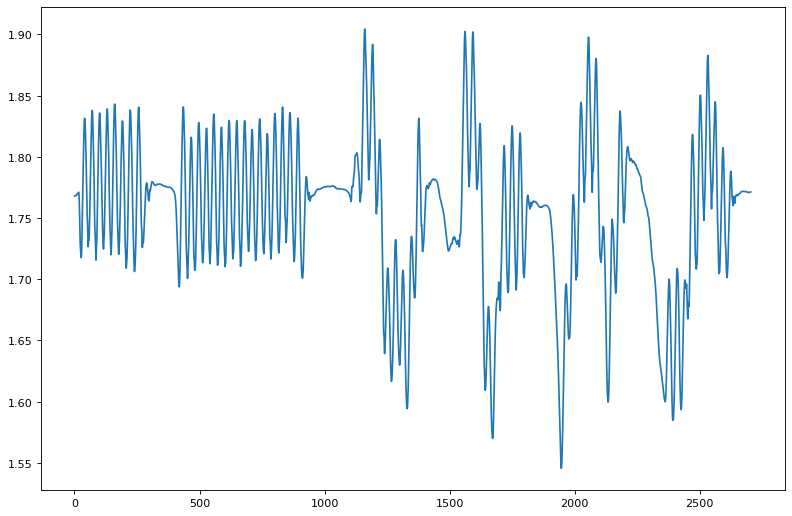

In [5]:
fig=plt.figure(figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k') # setting the size of the output
plt.plot(rec["head_position"][1::3]) # plot only the y coordinate of the head position

In [6]:
# this function uses the euler angles (in radian) and creates a 4x4 matrix that
# has the same layout as a godot basis: i.e. 
def godotEulerToMat4(x, y, z):
    return  glm.transpose(glm.rotate(glm.mat4(), -z, glm.vec3(0.0, 0.0, 1.0)) * \
            glm.rotate(glm.mat4(), -x, glm.vec3(1.0, 0.0, 0.0)) * \
            glm.rotate(glm.mat4(), -y, glm.vec3(0.0, 1.0, 0.0)));

35.67621035121564
11.563138285209451
1.7546394269870609
1.7831419294022008


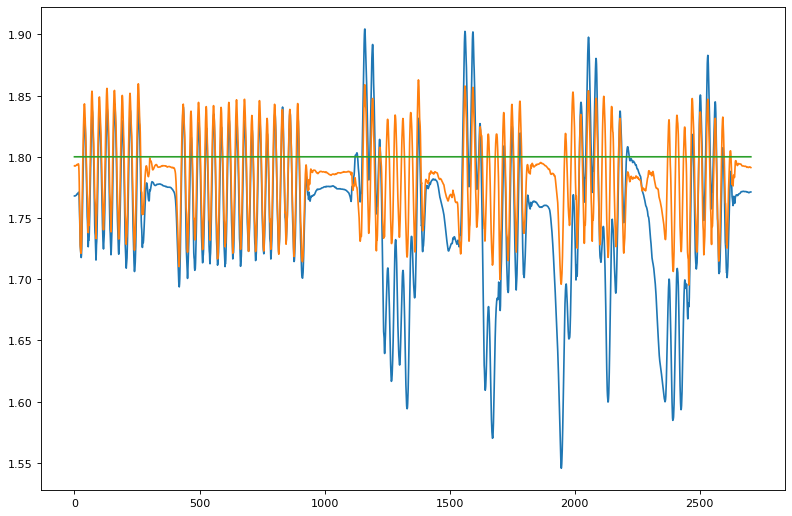

In [7]:
# note: there is probably a much more elegant solution to this
def rotationArrayToViewDir_Y(a):
    ret = [0.0] * (len(a)//3)
    for i in range(0, len(a), 3):
        ret[i//3] = -(godotEulerToMat4(a[i], a[i+1], a[i+2])[2].y); # basis.z.y ()
    return ret;
 
Cup = -0.06;
Cdown = -0.177;

# this is required to adjust for the different headset height based on if the user is looking up, down or straight
def _get_viewdir_corrected_height(h, viewdir_y):
    if (viewdir_y >= 0.0):
        return h + Cup * viewdir_y;
    else:
        return h + Cdown * viewdir_y;

def processHeightCorrection(h, s):
    ret = [0.0] * (len(h))
    for i in range(0, len(h)):
        ret[i] = _get_viewdir_corrected_height(h[i], s[i]);
    return ret;

        
hpy = np.array(rec["head_position"][1::3])
hoy = np.array(rotationArrayToViewDir_Y(rec["head_orientation"]))
hpy_corrected = np.array(processHeightCorrection(hpy, hoy));
fig=plt.figure(figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k') # setting the size of the output
plt.plot(hpy) # plot only the y coordinate of the head position
plt.plot(hpy_corrected) # plot only the y coordinate of the head position

plt.plot([1.8]*rec['num_frames'])

print(np.var(hpy) * 10000.0)
print(np.var(hpy_corrected) * 10000.0)
print(np.average(hpy))
print(np.average(hpy_corrected))

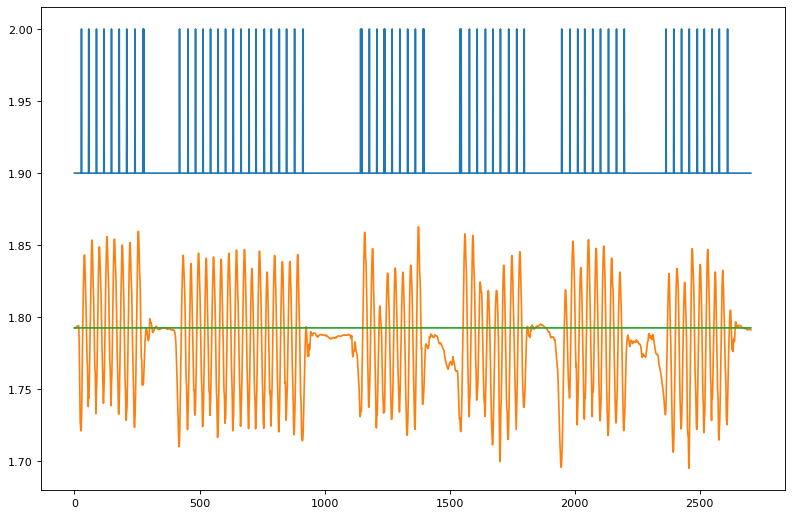

In [9]:
_height_ringbuffer_size = 5; # 5 seems fine in most of the cases so far; but maybe 7 could also work
_height_ringbuffer_pos = 0;
_height_ringbuffer = [0] * _height_ringbuffer_size;
_step_local_detect_threshold = 0.003; # local difference
_step_height_min_detect_threshold = 0.02; # This might need some tweaking now to avoid missed steps
_step_height_max_detect_threshold = 0.1; # This might need some tweaking now to avoid missed steps

_variance_height_detect_threshold = 0.0005;

variance_buffer = [];

_current_height_estimate = 0.0; # an estimate of the current actual head height to be able to detect step height

# I assume there is some shaking


def _get_buffered_height(i):
    return _height_ringbuffer[(_height_ringbuffer_pos + i) % _height_ringbuffer_size];

def _store_height_in_buffer(y):
    global _height_ringbuffer_pos;
    global _height_ringbuffer;
    global _height_ringbuffer_size;
    _height_ringbuffer[_height_ringbuffer_pos] = y;
    _height_ringbuffer_pos = (_height_ringbuffer_pos + 1) % _height_ringbuffer_size;
    
def detect_step():
    min_value = _get_buffered_height(0);
    
    global variance_buffer;
    global _current_height_estimate;
    
    average = min_value;
    max_diff = 0.0;
        
    p = 0;
    for i in range(1, _height_ringbuffer_size):
        val = _get_buffered_height(i);
        average += val;
        if (val < min_value):
            min_value = val;
            p = i;

    average = average / _height_ringbuffer_size;
    
    variance = 0.0;
    for i in range(0, _height_ringbuffer_size):
        val = _get_buffered_height(i);
        variance = variance + abs(average - val);
    variance = variance / _height_ringbuffer_size;
    variance_buffer.append(variance * 100);
    
    # if there is not much variation in the last _height_ringbuffer_size values we take the average as our current heigh
    # assuming that we are not in a step process then
    if (variance <= _variance_height_detect_threshold):
        _current_height_estimate = average;
        
    # this is now the actual step detection based on that the center value of the ring buffer is the actual minimum (the turning point)
    # and also the defined thresholds to minimize false detections as much as possible
    dist = _current_height_estimate - min_value;
    if (p == _height_ringbuffer_size // 2 
        and dist > _step_height_min_detect_threshold
        and dist < _step_height_max_detect_threshold
        #and (_get_buffered_height(0) - min_value) > _step_local_detect_threshold # this can avoid some local mis predicitons
       ): 
        return 1;
    else: return 0;
    
res = [];
height = [];
def sim():
    _current_height_estimate = hpy_corrected[0];
    c = 0;
    last_c = 0;
    for v in hpy_corrected:
        _store_height_in_buffer(v)
        step = detect_step()
        res.append(step);
        if (step == 1): 
            #print(c - last_c, end=' ');
            last_c = c;
        height.append(_current_height_estimate);
        c+=1;
        
sim();

st = 0;
num = 2800;
fig=plt.figure(figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k') # setting the size of the output
plt.plot(np.array(res[st:st+num]) * 0.1 + 1.9)
plt.plot((hpy_corrected[st:st+num]))
plt.plot((height[st:st+num]))
    